<a href="https://colab.research.google.com/github/maverick19-hub/Work/blob/main/TIME_SERIES_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Land Temperature Time Series Analysis (1990–2013)
# **Introduction**

Climate change has led to significant shifts in global temperature patterns over the past decades.

This analysis uses the Global Land Temperatures by City dataset to study temperature trends across multiple continents.

The time period 1990–2013 was selected for its consistent and modern data coverage.

The main goal is to analyze, visualize, and forecast temperature changes across different cities and continents.

Each continent is represented by at least two cities to provide balanced global insights.

The study combines time series techniques and geospatial visualization to explore climate dynamics.

# **Objectives**

Examine long-term temperature trends for selected cities.

Compare temperature changes across continents and hemispheres.

Identify patterns of seasonality, trend, and irregular fluctuations.

Forecast future temperature patterns using time series models.

Create interactive visualizations for dynamic presentation and analysis.


# New Section
**Expected Outcomes**

Clear visualization of warming trends per continent.

Comparison of temperature evolution between urban centers.

Interactive dashboards to present global and regional temperature behavior.

Foundation for climate forecasting and policy-related discussions.

In [2]:
%pip install pycountry_convert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.6/250.6 kB 18.8 MB/s eta 0:00:00


In [3]:
# LOAD AND INSPECT DATASET

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pycountry_convert as pc
import warnings
warnings.filterwarnings("ignore")

# Load dataset
df = pd.read_csv("/content/GlobalLandTemperaturesByCity.csv")

# Convert date column to datetime
df['dt'] = pd.to_datetime(df['dt'])

# Rename for simplicity
df.rename(columns={
    'dt': 'Date',
    'AverageTemperature': 'Temp',
    'AverageTemperatureUncertainty': 'Temp_Uncertainty'
}, inplace=True)

# Drop missing temps
df = df.dropna(subset=['Temp'])

print("Data range:", df['Date'].min(), "→", df['Date'].max())
print("Total rows:", len(df))
print(df.head())


Data range: 1743-11-01 00:00:00 → 2013-09-01 00:00:00
Total rows: 8235082
        Date    Temp  Temp_Uncertainty   City  Country Latitude Longitude
0 1743-11-01   6.068             1.737  Århus  Denmark   57.05N    10.33E
5 1744-04-01   5.788             3.624  Århus  Denmark   57.05N    10.33E
6 1744-05-01  10.644             1.283  Århus  Denmark   57.05N    10.33E
7 1744-06-01  14.051             1.347  Århus  Denmark   57.05N    10.33E
8 1744-07-01  16.082             1.396  Århus  Denmark   57.05N    10.33E


In [5]:
# FILTER DATA BETWEEN 1990 AND 2013

# Keep only records from 1990–2013
df = df[(df['Date'] >= '1990-01-01') & (df['Date'] <= '2013-12-31')]

# Confirm the filtered range
print("Filtered data range:", df['Date'].min(), "→", df['Date'].max())
print("Remaining rows:", len(df))


Filtered data range: 1990-01-01 00:00:00 → 2013-09-01 00:00:00
Remaining rows: 997280


In [7]:
# ADD CONTINENT INFORMATION

import pycountry
import pycountry_convert as pc

# Get unique countries
unique_countries = df['Country'].unique()

# Cache results
country_continent_map = {}

def country_to_continent_fast(country_name):
    if country_name in country_continent_map:
        return country_continent_map[country_name]
    try:
        country = pycountry.countries.search_fuzzy(country_name)[0]
        code = country.alpha_2
        cont_code = pc.country_alpha2_to_continent_code(code)
        cont_name = {
            "AF": "Africa",
            "AS": "Asia",
            "EU": "Europe",
            "NA": "North America",
            "SA": "South America",
            "OC": "Oceania"
        }[cont_code]
        country_continent_map[country_name] = cont_name
        return cont_name
    except:
        country_continent_map[country_name] = None
        return None

df['Continent'] = df['Country'].apply(country_to_continent_fast)
df = df.dropna(subset=['Continent'])



In [10]:
# SELECT REPRESENTATIVE CITIES

city_years = df.groupby(['City','Country','Continent'])['Date'].agg(['min','max','count']).reset_index()
city_years['Years'] = (city_years['max'] - city_years['min']).dt.days / 365.25
selected = []

for cont in city_years['Continent'].unique():
    subset = city_years[city_years['Continent'] == cont]
    subset = subset[subset['Years'] > 17]  # only long records
    chosen = subset.sort_values('count', ascending=False).head(2)
    selected.extend(chosen[['City','Country','Continent']].values.tolist())

print("Selected cities per continent: ")
for c in selected:
    print(f" - {c[0]}, {c[1]} ({c[2]})")


Selected cities per continent: 
 - Århus, Denmark (Europe)
 - A Coruña, Spain (Europe)
 - Wahran, Algeria (Africa)
 - Wad Madani, Sudan (Africa)
 - Rongcheng, China (Asia)
 - Depok, Indonesia (Asia)
 - Springfield, United States (North America)
 - Columbus, United States (North America)
 - Cartagena, Colombia (South America)
 - Maicao, Colombia (South America)
 - Adelaide, Australia (Oceania)
 - Albury, Australia (Oceania)


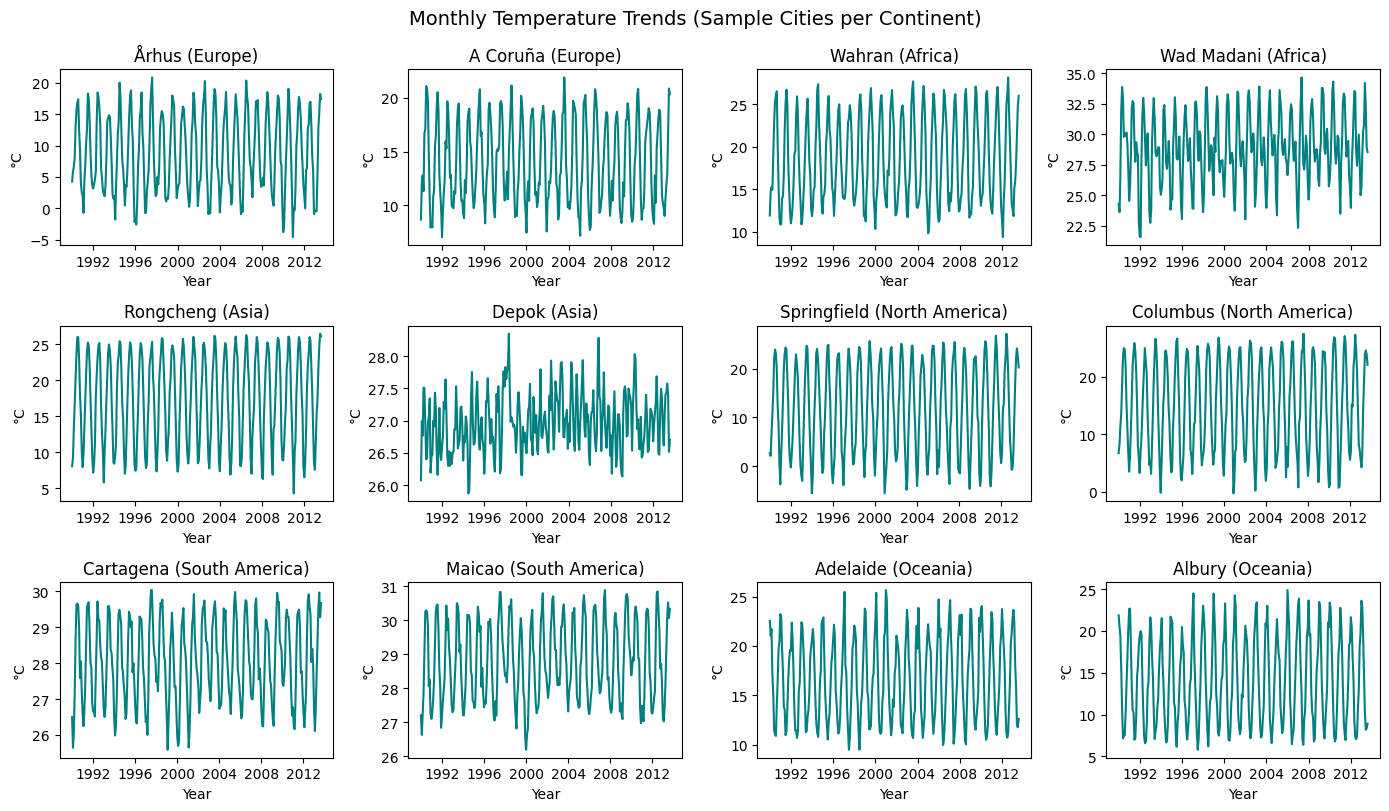

In [11]:
# CITY TEMPERATURE TREND PLOTS

plt.figure(figsize=(14,10))

for i,(city,country,cont) in enumerate(selected):
    data = df[(df['City']==city) & (df['Country']==country)]
    data = data.groupby('Date')['Temp'].mean().reset_index()

    plt.subplot(4,4,i+1)
    plt.plot(data['Date'], data['Temp'], color='teal')
    plt.title(f"{city} ({cont})")
    plt.xlabel("Year")
    plt.ylabel("°C")
    plt.tight_layout()

plt.suptitle("Monthly Temperature Trends (Sample Cities per Continent)", fontsize=14, y=1.02)
plt.show()


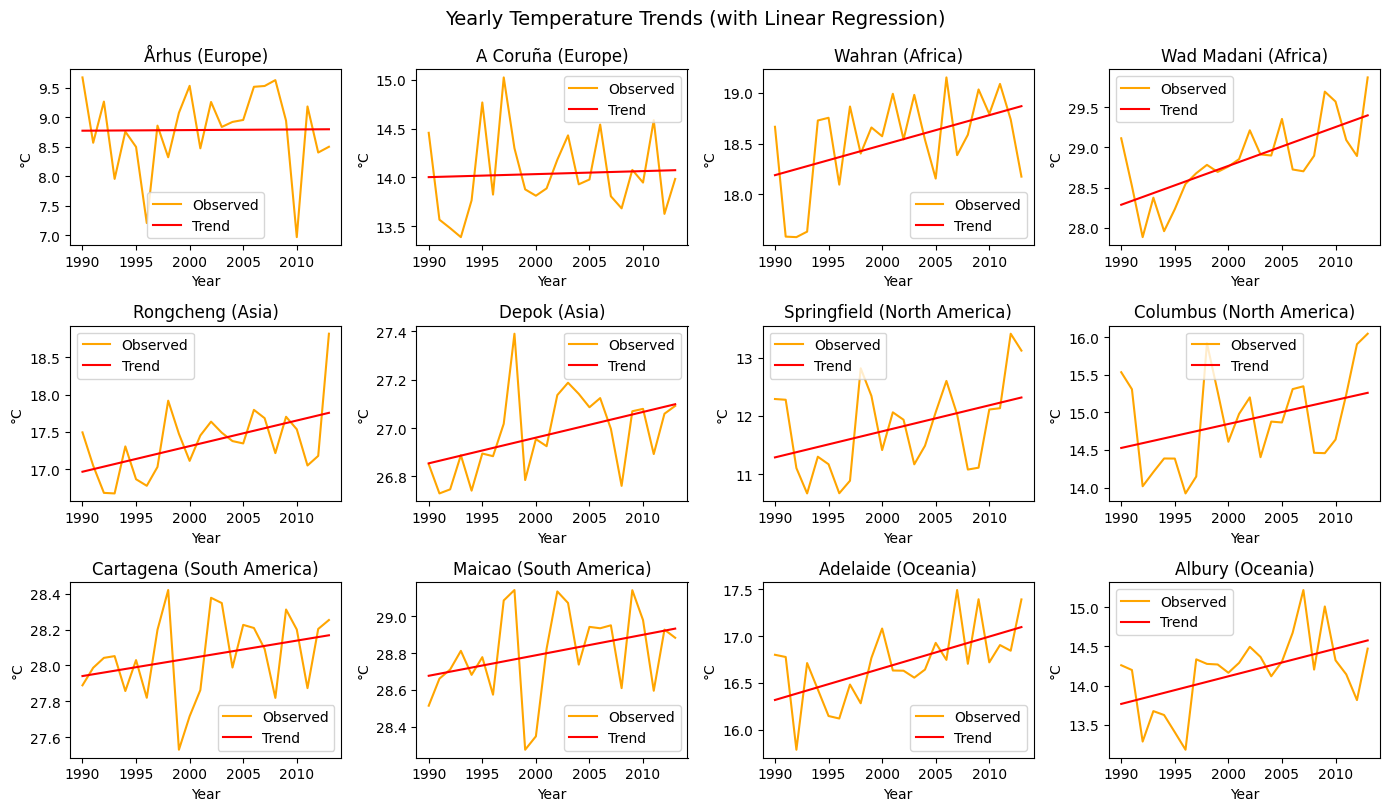

In [12]:
# YEARLY AVERAGES AND LINEAR TRENDLINES

from sklearn.linear_model import LinearRegression

plt.figure(figsize=(14,10))

for i,(city,country,cont) in enumerate(selected):
    data = df[(df['City']==city) & (df['Country']==country)]
    yearly = data.groupby(data['Date'].dt.year)['Temp'].mean().reset_index()

    # Fit trendline
    X = yearly[['Date']]
    y = yearly['Temp']
    model = LinearRegression().fit(X, y)
    trend = model.predict(X)

    plt.subplot(4,4,i+1)
    plt.plot(yearly['Date'], yearly['Temp'], label="Observed", color='orange')
    plt.plot(yearly['Date'], trend, label="Trend", color='red')
    plt.title(f"{city} ({cont})")
    plt.xlabel("Year")
    plt.ylabel("°C")
    plt.legend()
    plt.tight_layout()

plt.suptitle("Yearly Temperature Trends (with Linear Regression)", fontsize=14, y=1.02)
plt.show()


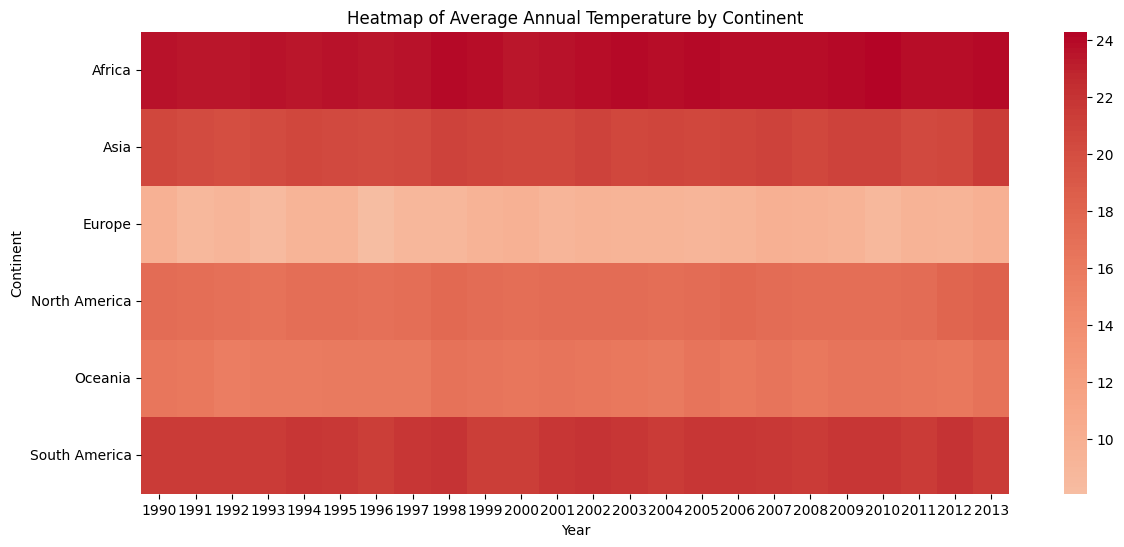

In [14]:
# CONTINENT HEATMAP

df['Year'] = df['Date'].dt.year
cont_yearly = df.groupby(['Continent','Year'])['Temp'].mean().reset_index()
pivot = cont_yearly.pivot(index='Continent', columns='Year', values='Temp')

plt.figure(figsize=(14,6))
sns.heatmap(pivot, cmap='coolwarm', center=1)
plt.title("Heatmap of Average Annual Temperature by Continent")
plt.xlabel("Year")
plt.ylabel("Continent")
plt.show()


In [21]:
# --- FIX LATITUDE AND LONGITUDE FORMAT ---
def convert_lat(lat_str):
    if isinstance(lat_str, str):
        val = float(lat_str[:-1])
        return val if lat_str[-1] == 'N' else -val
    return lat_str

def convert_lon(lon_str):
    if isinstance(lon_str, str):
        val = float(lon_str[:-1])
        return val if lon_str[-1] == 'E' else -val
    return lon_str

df['Latitude'] = df['Latitude'].apply(convert_lat)
df['Longitude'] = df['Longitude'].apply(convert_lon)


In [25]:
print(df.columns)


Index(['Date', 'Temp', 'Temp_Uncertainty', 'City', 'Country', 'Latitude',
       'Longitude', 'Continent', 'Year'],
      dtype='object')


In [26]:
# TEMPERATURE FORECASTING (1990–2023) ---

import pandas as pd
import numpy as np
import plotly.graph_objects as go
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

forecast_cities = ['Nairobi', 'Paris', 'Tokyo', 'New York']

def forecast_city_temp(city_name, df, steps_ahead=120):
    print(f"\n🔹 Forecasting for {city_name}...\n")

    # Ensure proper date format
    df['Date'] = pd.to_datetime(df['Date'])

    # Filter for city and prepare data
    city_df = df[df['City'] == city_name].copy()
    city_df = city_df[['Date', 'Temp']].dropna()
    city_df.set_index('Date', inplace=True)

    # Resample monthly to smooth noise
    city_monthly = city_df['Temp'].resample('M').mean()

    # Split train and test sets
    train = city_monthly[:'2010']
    test = city_monthly['2011':]

    # --- Model 1: Holt-Winters ---
    hw_model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit()
    hw_forecast = hw_model.forecast(len(test))

    # --- Model 2: ARIMA ---
    arima_model = ARIMA(train, order=(2,1,2)).fit()
    arima_forecast = arima_model.forecast(len(test))

    # Evaluate accuracy
    hw_rmse = np.sqrt(mean_squared_error(test, hw_forecast))
    arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))

    print(f"✅ Holt-Winters RMSE: {hw_rmse:.3f}")
    print(f"✅ ARIMA RMSE: {arima_rmse:.3f}")

    # Forecast for 2014–2023
    future_hw = hw_model.forecast(steps=steps_ahead)
    future_arima = arima_model.forecast(steps=steps_ahead)

    # --- Plot interactive forecast ---
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=city_monthly.index, y=city_monthly,
                             mode='lines', name='Actual', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=future_hw.index, y=future_hw,
                             mode='lines', name='HW Forecast', line=dict(dash='dot', color='orange')))
    fig.add_trace(go.Scatter(x=future_arima.index, y=future_arima,
                             mode='lines', name='ARIMA Forecast', line=dict(dash='dash', color='red')))

    fig.update_layout(
        title=f"{city_name}: Temperature Forecast (1990–2023)",
        xaxis_title='Year',
        yaxis_title='Average Temperature (°C)',
        template='plotly_white',
        legend=dict(x=0.01, y=0.99)
    )
    fig.show()

# Run forecasts for the selected cities
for city in forecast_cities:
    forecast_city_temp(city, df)



🔹 Forecasting for Nairobi...

✅ Holt-Winters RMSE: 0.405
✅ ARIMA RMSE: 0.889



🔹 Forecasting for Paris...

✅ Holt-Winters RMSE: 1.741
✅ ARIMA RMSE: 3.144



🔹 Forecasting for Tokyo...

✅ Holt-Winters RMSE: 1.247
✅ ARIMA RMSE: 1.983



🔹 Forecasting for New York...

✅ Holt-Winters RMSE: 1.628
✅ ARIMA RMSE: 2.423


In [22]:
# GLOBAL TEMPERATURE MAP (AVERAGE BY CITY) ---

import plotly.express as px

# Get mean temperature per city (recent years only)
recent = df[df['Date'].dt.year >= 2000]
city_means = recent.groupby(['City','Country','Latitude','Longitude'])['Temp'].mean().reset_index()

# Plot interactive globe
fig = px.scatter_geo(city_means,
                     lat='Latitude', lon='Longitude',
                     color='Temp',
                     hover_name='City',
                     color_continuous_scale='RdYlBu_r',
                     title="Global Average Temperature by City (2000–2013)")
fig.show()


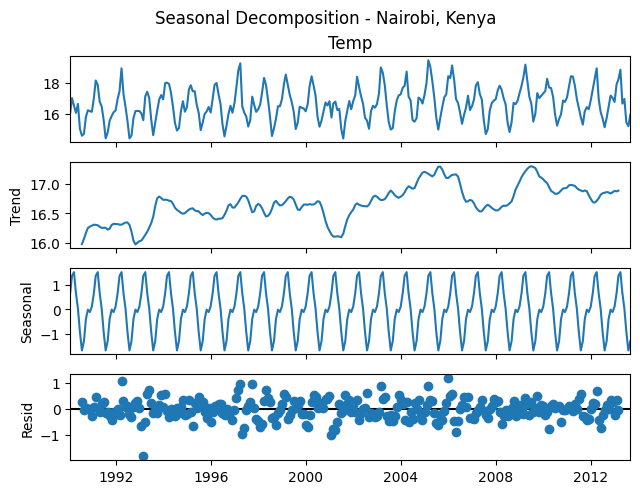

In [17]:
# SEASONALITY DECOMPOSITION

from statsmodels.tsa.seasonal import seasonal_decompose

example_city = "Nairobi"
example_country = "Kenya"

data = df[(df['City']==example_city) & (df['Country']==example_country)]
data = data.set_index('Date').resample('M')['Temp'].mean().dropna()

decomp = seasonal_decompose(data, model='additive', period=12)
decomp.plot()
plt.suptitle(f"Seasonal Decomposition - {example_city}, {example_country}", y=1.02)
plt.show()

In [18]:
import plotly.express as px

# Filter for selected cities
sel_cities = [c[0] for c in selected]
sel_data = df[df['City'].isin(sel_cities)]

# Aggregate monthly mean
trend_data = sel_data.groupby(['City', df['Date'].dt.to_period('M')])['Temp'].mean().reset_index()
trend_data['Date'] = trend_data['Date'].astype(str)

# Interactive line chart
fig = px.line(
    trend_data,
    x='Date', y='Temp',
    color='City',
    line_group='City',
    title="Interactive Temperature Trends (1990–2013)",
    labels={'Temp': 'Temperature (°C)', 'Date': 'Year'},
)

fig.update_layout(hovermode="x unified")
fig.show()


In [20]:
print(city_means.shape)
print(city_means.head())


(3414, 5)
       City  Country Latitude Longitude       Temp
0  A Coruña    Spain   42.59N     8.73W  14.034128
1    Aachen  Germany   50.63N     6.34E  10.031000
2   Aalborg  Denmark   57.05N    10.33E   8.911165
3       Aba  Nigeria    5.63N     8.07E  27.363220
4    Abadan     Iran   29.74N    48.00E  26.424841


In [23]:
fig = px.scatter_geo(
    city_means,
    lat='Latitude', lon='Longitude',
    color='Temp',
    hover_name='City',
    projection='natural earth',
    color_continuous_scale='RdYlBu_r',
    title="Global Average Temperature by City (2000–2013)"
)
fig.update_geos(showcoastlines=True, showland=True, landcolor="lightgray")
fig.show()
